In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
from matplotlib import rc
import matplotlib.font_manager as fm

fm._rebuild()
fm.get_fontconfig_fonts()

# 디렉토리 및 파일 이름에 맞추어 변경
font_location = 'C:/Users/bsmon/OneDrive/바탕 화면/nanum-all/나눔 글꼴/나눔고딕/NanumGothic.ttf'

font_name = fm.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)

In [7]:
demo = pd.read_csv("D:\롯데 멤버십\데이터\LPOINT_BIG_COMP_01_DEMO.csv")
pdde = pd.read_csv("D:\롯데 멤버십\데이터\LPOINT_BIG_COMP_02_PDDE.csv")
cop_u = pd.read_csv("D:\롯데 멤버십\데이터\LPOINT_BIG_COMP_03_COP_U.csv")
pd_clac = pd.read_csv("D:\롯데 멤버십\데이터\LPOINT_BIG_COMP_04_PD_CLAC.csv")
br = pd.read_csv("D:\롯데 멤버십\데이터\LPOINT_BIG_COMP_05_BR.csv")
lpay = pd.read_csv("D:\롯데 멤버십\데이터\LPOINT_BIG_COMP_06_LPAY.csv")

# EDA

* 고객층이 가장 많은 40대+ 오프라인 매장의 비율이 압도적을 높음  
=> 날씨의 영향이 크다
* 날씨별 차이를 보이는 분류를 찾음
* 이 때 날씨의 상관 없이 특이한 값을 보이는 제품들(시계,보석 같은)은 이상치 제거를 통해 추천 시스템에 영향을 줄임

In [70]:
sns.set_theme(style="ticks", palette="pastel")

<AxesSubplot:xlabel='chnl_dv', ylabel='count'>

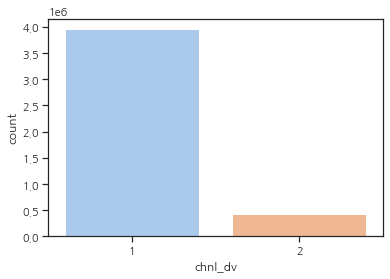

In [135]:
sns.countplot(data=pdde,x = 'chnl_dv')

<AxesSubplot:xlabel='ages', ylabel='count'>

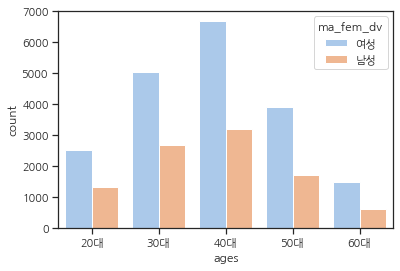

In [74]:
order = ["20대","30대","40대","50대","60대"]
sns.countplot(data = demo, x = "ages", hue = "ma_fem_dv",order=order)

In [8]:
pdde_demo = pd.merge(pdde,demo,on=["cust"], how = "inner")

In [9]:
pdde_demo_pd_clac = pd.merge(pdde_demo,pd_clac,on=["pd_c"], how = "inner")

In [137]:
pdde_demo_pd_clac.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4381743 entries, 0 to 4381742
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   cust          object        
 1   rct_no        object        
 2   chnl_dv       int64         
 3   cop_c         object        
 4   br_c          object        
 5   pd_c          object        
 6   de_dt         datetime64[ns]
 7   de_hr         int64         
 8   buy_am        float64       
 9   buy_ct        int64         
 10  ma_fem_dv     object        
 11  ages          object        
 12  zon_hlv       object        
 13  pd_nm         object        
 14  clac_hlv_nm   object        
 15  clac_mcls_nm  object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(11)
memory usage: 568.3+ MB


## 날씨 데이터 병합
* 수도권의 2021년 날씨를 가져옴
* 비가 오고/안 오고로 구분
* 날씨는 추움 더움 보통으로 구분

In [11]:
from bs4 import BeautifulSoup
import urllib.request
from urllib.parse import quote
import pandas as pd

data = []
tmp = []
y = 2021
weather_df = pd.DataFrame(columns=("Date", "Day", "AT", "TT", "MT", "Rain"))


for m in range(1, 13):
    url = f"https://www.weather.go.kr/w/obs-climate/land/past-obs/obs-by-day.do?stn=108&yy=" + str(y) + "&mm=" + str(m) + "&obs=1"
    weather_month = urllib.request.urlopen(url).read()
    weather_month_soup = BeautifulSoup(weather_month, 'html.parser')

    table = weather_month_soup.find('table', {'class': 'table-col table-cal'})

    if m < 10:
        m = '0' + str(m)

    count = 0
    point = [''] * 7
    pointt = [''] * 7
    fstr = [''] * 7
    tstr = [''] * 7
    mstr = [''] * 7
    estr = [''] * 7
    temp = [''] * 7        # 평균 기온
    temptop = [''] * 7     # 최고 기온
    tempmin = [''] * 7     # 최저 기온
    rain = [''] * 7        # 강수량

    for tr in table.find_all('tr'):
        tds = list(tr.find_all('td'))

        if tds:
            for i in range(0, 7):
                point[i] = tds[i].text

            if count % 2 != 0:
                for j in range(0, 7):
                    num = point[j].translate({ord('일'): ''})
                    pointt[j] = ((num.strip()).zfill(2)).replace('00', '')

            if count % 2 == 0:
                for k in range(0, 7):
                    fstr[k] = point[k].find('최고기온')
                    tstr[k] = point[k].find('최저기온')
                    mstr[k] = point[k].find('평균운량')
                    estr[k] = point[k].find('일강수량')
                    temp[k] = point[k][6:fstr[k]].translate({ord('℃'): ''})
                    temptop[k] = point[k][fstr[k] + 5:tstr[k]].translate({ord('℃'): ''})
                    tempmin[k] = point[k][tstr[k] + 5:mstr[k]].translate({ord('℃'): ''})
                    rain[k] = point[k][estr[k] + 5:].translate({ord(' '): '', ord('-'): '0.0', ord('m'): ''})

                if pointt[0] == '\xa0' or temp[0] == '':
                    sun = ""
                else:
                    sun = str(y) + str(m) + pointt[0].strip() + ',' + 'sun' + ',' + temp[0].strip() + ',' + temptop[0].strip() + ',' + tempmin[
                        0].strip() + ',' + rain[0].strip()
                    tmp = sun.split(',')
                    data.append(tmp)

                if pointt[1] == '\xa0' or temp[1] == '':
                    mon = ""
                else:
                    mon = str(y) + str(m) + pointt[1].strip() + ',' + 'mon' + ',' + temp[1].strip() + ',' + temptop[1].strip() + ',' + tempmin[
                        1].strip() + ',' + rain[1].strip()
                    tmp = mon.split(',')
                    data.append(tmp)

                if pointt[2] == '\xa0' or temp[2] == '':
                    tue = ""
                else:
                    tue = str(y) + str(m) + pointt[2].strip() + ',' + 'tue' + ',' + temp[2].strip() + ',' + temptop[2].strip() + ',' + tempmin[
                        2].strip() + ',' + rain[2].strip()
                    tmp = tue.split(',')
                    data.append(tmp)

                if pointt[3] == '\xa0' or temp[3] == '':
                    wed = ""
                else:
                    wed = str(y) + str(m) + pointt[3].strip() + ',' + 'wed' + ',' + temp[3].strip() + ',' + temptop[3].strip() + ',' + tempmin[
                        3].strip() + ',' + rain[3].strip()
                    tmp = wed.split(',')
                    data.append(tmp)

                if pointt[4] == '\xa0' or temp[4] == '':
                    thu = ""
                else:
                    thu = str(y) + str(m) + pointt[4].strip() + ',' + 'thu' + ',' + temp[4].strip() + ',' + temptop[4].strip() + ',' + tempmin[
                        4].strip() + ',' + rain[4].strip()
                    tmp = thu.split(',')
                    data.append(tmp)

                if pointt[5] == '\xa0' or temp[5] == '':
                    fri = ""
                else:
                    fri = str(y) + str(m) + pointt[5].strip() + ',' + 'fri' + ',' + temp[5].strip() + ',' + temptop[5].strip() + ',' + tempmin[
                        5].strip() + ',' + rain[5].strip()
                    tmp = fri.split(',')
                    data.append(tmp)

                if pointt[6] == '\xa0' or temp[6] == '':
                    sat = ""
                else:
                    sat = str(y) + str(m) + pointt[6].strip() + ',' + 'sat' + ',' + temp[6].strip() + ',' + temptop[6].strip() + ',' + tempmin[
                        6].strip() + ',' + rain[6].strip()
                    tmp = sat.split(',')
                    data.append(tmp)

        count += 1

inx = 0
for i in range(0, len(data)):
    weather_df.loc[inx] = [data[i][0], data[i][1], data[i][2], data[i][3], data[i][4], data[i][5]]
    inx += 1

print(weather_df.to_string(index=False))  # 인덱스 없이 출력

     Date  Day     AT     TT     MT  Rain
 20210101  fri   -4.2    1.6   -9.8   0.0
 20210102  sat   -5.0   -1.4   -8.4   0.0
 20210103  sun   -5.6   -2.0   -9.1   0.0
 20210104  mon   -3.5    0.3   -8.4   0.0
 20210105  tue   -5.5   -2.1   -9.9   0.0
 20210106  wed   -7.4   -1.9  -12.0   2.3
 20210107  thu  -14.5   -8.4  -16.5   0.0
 20210108  fri  -14.9  -10.7  -18.6   0.0
 20210109  sat  -12.2   -7.5  -16.6   0.0
 20210110  sun   -7.7   -2.7  -12.8   0.0
 20210111  mon   -6.7   -4.0   -9.6   0.0
 20210112  tue   -3.9   -0.5   -9.3   2.6
 20210113  wed    2.0    8.3   -3.0   0.0
 20210114  thu    1.7    7.0   -3.6   0.0
 20210115  fri    4.5    9.9   -0.7   0.2
 20210116  sat   -4.9   -0.7   -8.7   0.0
 20210117  sun   -5.5   -1.3  -10.8   0.0
 20210118  mon   -3.8    0.2   -9.1   0.3
 20210119  tue   -6.3   -0.2  -11.6   0.0
 20210120  wed   -0.1    7.1   -6.6   0.0
 20210121  thu    4.5    7.0    2.5   9.2
 20210122  fri    5.5    6.6    4.8   0.1
 20210123  sat    7.6   12.2    4.

In [12]:
weather_df["Date"] = pd.to_datetime(weather_df["Date"])

In [13]:
weather_df["Rain"]=weather_df["Rain"].astype("float")
weather_df["AT"]=weather_df["AT"].astype("float")

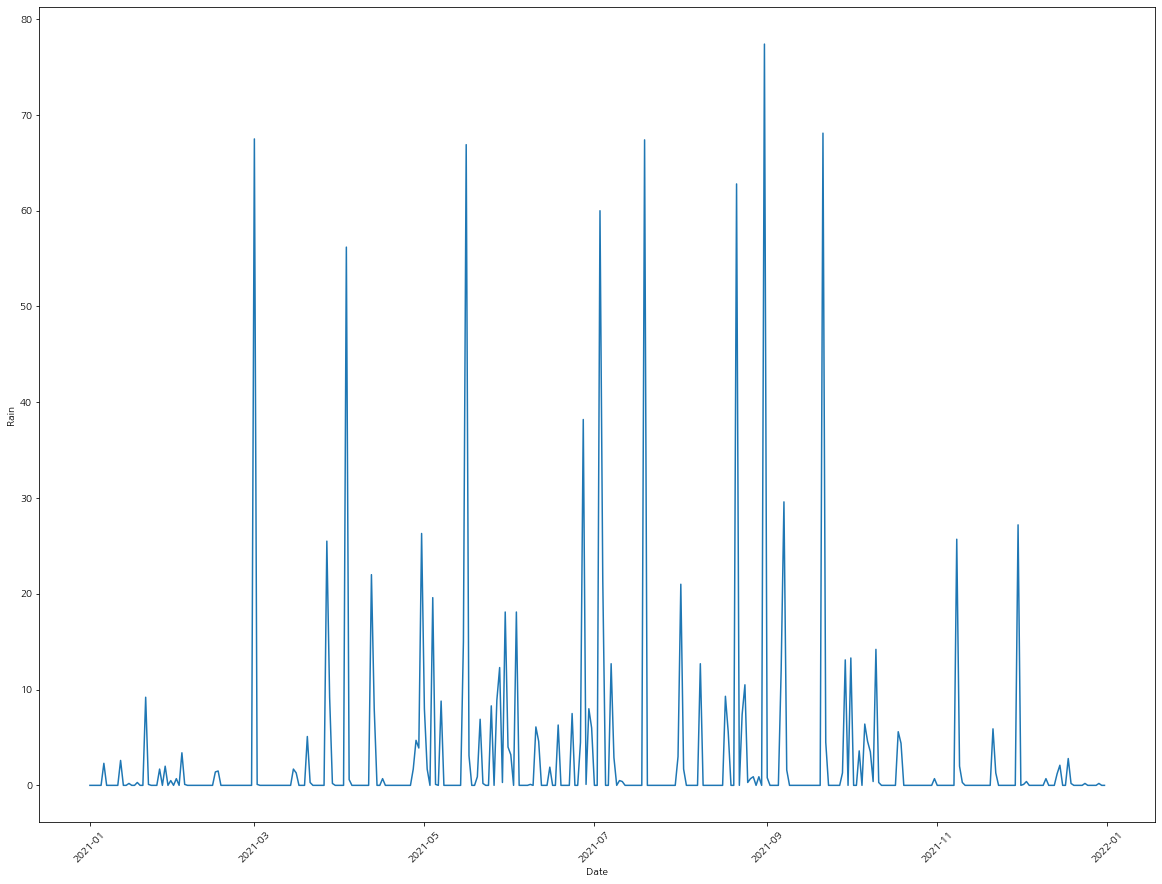

In [14]:
plt.figure(figsize=(20,15))
sns.lineplot(data = weather_df, x = "Date", y = "Rain")
plt.xticks(rotation=45)
plt.show()

In [23]:
weather = []

for i in weather_df["AT"]:
    if i<=10:
        weather.append("cold")
    elif i>10 and i<=25:
        weather.append("warm") 
    else:
        weather.append("hot")

In [24]:
rain_state = []

for i in weather_df["Rain"]:
    if i>=0 and i<2.5:
        rain_state.append("no_rain")
    elif i>=2.5:
        rain_state.append("rain")
#     elif i>=10 and i<20:
#         rain_state.append("thick_rain")
#     elif i>=20 and i<30:
#         rain_state.append("many_rain")
#     elif i>=30 and i<50:
#         rain_state.append("heavy_rain")
#     else:
#         rain_state.append("disaster")

In [25]:
weather_df["weather"] = weather
weather_df["Rain_status"] = rain_state

In [26]:
weather_df_drop = weather_df.drop(["AT","TT","MT","Rain"],axis=1)

In [27]:
pdde_demo_pd_clac["de_dt"] = pdde_demo_pd_clac["de_dt"].astype('string')
pdde_demo_pd_clac["de_dt"] = pd.to_datetime(pdde_demo_pd_clac["de_dt"])

In [28]:
pdde_demo_pd_clac_weather = pd.merge(pdde_demo_pd_clac,weather_df_drop,left_on = "de_dt",right_on = "Date",how="inner")

In [29]:
pdde_demo_pd_clac_weather.groupby(["weather","Rain_status"]).count()

cust   rct_no  chnl_dv    cop_c     br_c     pd_c  \
weather Rain_status                                                         
cold    no_rain      1474711  1474711  1474711  1474711  1277901  1474711   
        rain          116203   116203   116203   116203   100456   116203   
hot     no_rain       509690   509690   509690   509690   489726   509690   
        rain           79394    79394    79394    79394    76097    79394   
warm    no_rain      1606194  1606194  1606194  1606194  1462093  1606194   
        rain          595551   595551   595551   595551   546969   595551   

                       de_dt    de_hr   buy_am   buy_ct  ma_fem_dv     ages  \
weather Rain_status                                                           
cold    no_rain      1474711  1474711  1474711  1474711    1474711  1474711   
        rain          116203   116203   116203   116203     116203   116203   
hot     no_rain       509690   509690   509690   509690     509690   509690   
        rain           79394    79394    79394    79394      79394    79394   
warm    no_rain      1606194  1606194  1606194  1606194    1606194  1606194   
        rain          595551   595551   595551   595551     595551   595551   

                     zon_hlv    pd_nm  clac_hlv_nm  clac_mcls_nm     Date  \
weather Rain_status                                                         
cold    no_rain      1474711  1474711      1474711       1474711  1474711   
        rain          116203   116203       116203        116203   116203   
hot     no_rain       509690   509690       509690        509690   509690   
        rain           79394    79394        79394         79394    79394   
warm    no_rain      1606194  1606194      1606194       1606194  1606194   
        rain          595551   595551       595551        595551   595551   

                         Day  
weather Rain_status           
cold    no_rain      1474711  
        rain          116203  
hot     no_rain       509690  
        rain           79394  
warm    no_rain      1606194  
        rain          595551

## 인구 데이터를 통한 지역 유추
* 한국 인구를 내림차순 하면 고객 데이터의 지역 수와 비슷한 분포를 보임
* 이를 통해 지역을 유추 할 수 있음
* 날씨에 맞는 수도/경기권만 추출

In [53]:
people = pd.read_csv("D:/롯데 멤버십/행정구역_시군구_별__성별_인구수_20220811201435.csv",encoding='cp949',header=1)

In [54]:
people

,행정구역(시군구)별,총인구수 (명),남자인구수 (명),여자인구수 (명)
0,전국,51638809,25746684,25892125
1,서울특별시,9509458,4618040,4891418
2,부산광역시,3350380,1639044,1711336
3,대구광역시,2385412,1175632,1209780
4,인천광역시,2948375,1476373,1472002
5,광주광역시,1441611,713015,728596
6,대전광역시,1452251,724626,727625
7,울산광역시,1121592,576217,545375
8,세종특별자치시,371895,185678,186217
9,경기도,13565450,6827298,6738152


In [56]:
data_people = people[["행정구역(시군구)별","총인구수 (명)"]].drop(0,axis=0)

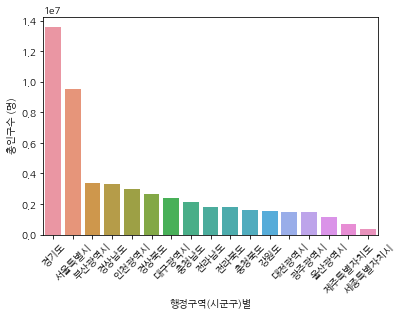

In [66]:
sns.barplot(data = data_people.sort_values(by = "총인구수 (명)", ascending = False), x = "행정구역(시군구)별", y = "총인구수 (명)")
plt.xticks(rotation=45)
plt.show()

<AxesSubplot:xlabel='zon_hlv', ylabel='count'>

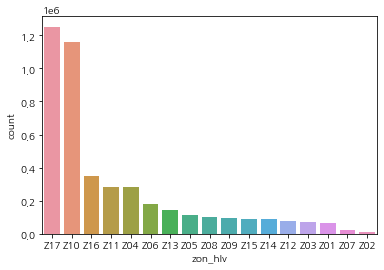

In [37]:
sns.countplot(data = pdde_demo_pd_clac_weather, x = "zon_hlv",order = pdde_demo_pd_clac_weather.zon_hlv.value_counts().index)

### 이상치 제거
* 가장 보편적인 방식인 IQR을 활용하여 각 대분류별 이상치 값을 제거
* buy_am/buy_ct를 통하여 제품의 가격을 측정
* 이를 이용하여 이상치를 제거

In [76]:
pdde_demo_pd_clac_weather["price"] = pdde_demo_pd_clac_weather["buy_am"]/pdde_demo_pd_clac_weather["buy_ct"]

In [107]:
#서울 경기
data_40 = pdde_demo_pd_clac_weather[(pdde_demo_pd_clac_weather.zon_hlv == "Z10") | (pdde_demo_pd_clac_weather.zon_hlv == "Z17")]

#여자
data_40_fe = data_40[(data_40.ages=="40대") & (data_40.ma_fem_dv == "여성")]

#남자
data_40_m = data_40[(data_40.ages=="40대")& (data_40.ma_fem_dv == "남성")]

In [78]:
data_40_m

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,ages,zon_hlv,pd_nm,clac_hlv_nm,clac_mcls_nm,Date,Day,weather,Rain_status,price
10,M123475113,A01000117354,1,A01,A010045,PD0290,2021-01-01,15,4800.0,1,...,40대,Z17,남성티셔츠,남성의류,남성의류상의,2021-01-01,fri,cold,no_rain,4800.0
62,M746883277,A02050676946,1,A02,A020010,PD1692,2021-01-01,13,1800.0,1,...,40대,Z10,커피/음료,테넌트/음식점,식당,2021-01-01,fri,cold,no_rain,1800.0
66,M886244263,A02000009900,1,A02,A020001,PD1692,2021-01-01,17,500.0,1,...,40대,Z10,커피/음료,테넌트/음식점,식당,2021-01-01,fri,cold,no_rain,500.0
107,M787230031,E02000089870,2,A02,NaN,PD0238,2021-01-01,9,4780.0,1,...,40대,Z17,판초콜릿,과자,초콜릿,2021-01-01,fri,cold,no_rain,4780.0
108,M787230031,E02000089870,2,A02,NaN,PD0238,2021-01-01,9,4780.0,1,...,40대,Z17,판초콜릿,과자,초콜릿,2021-01-01,fri,cold,no_rain,4780.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381632,M463455173,A04113920475,1,A04,A043225,PD1261,2021-11-18,22,1700.0,1,...,40대,Z10,치킨류,조리식품,온장조리,2021-11-18,thu,warm,no_rain,1700.0
4381648,M505013465,A03073363915,1,A03,A030118,PD0322,2021-11-18,17,3990.0,1,...,40대,Z17,냉동부침,냉동식품,냉동간편식,2021-11-18,thu,warm,no_rain,3990.0
4381649,M505013465,A03073363915,1,A03,A030118,PD0322,2021-11-18,17,5990.0,1,...,40대,Z17,냉동부침,냉동식품,냉동간편식,2021-11-18,thu,warm,no_rain,5990.0
4381671,M889012804,A02080086133,1,A02,A020007,PD1113,2021-11-18,11,900.0,9,...,40대,Z17,여아점퍼,유아동의류,여아의류아우터,2021-11-18,thu,warm,no_rain,100.0


In [95]:
expensive = data_40_m.pivot_table(index = ["pd_nm"],values=["price"],aggfunc="max").sort_values(by="price").sort_values(by="price",ascending=False)
expensive.reset_index()

,pd_nm,price
0,남성시계,48380000.0
1,반지,38870000.0
2,기타보석류,37070000.0
3,기타남성의류세트,36550000.0
4,기타패션잡화,30680000.0
...,...,...
1694,영유아레깅스,1000.0
1695,기타스키/보드용품,790.0
1696,봉투보증금,150.0
1697,영유아스커트,100.0


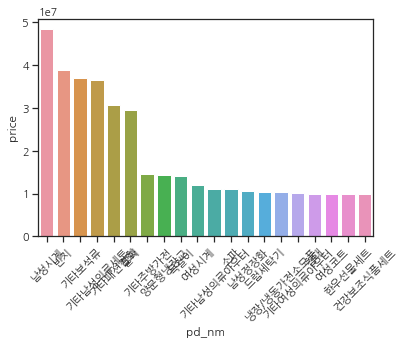

In [97]:
sns.barplot(data=expensive[:20].reset_index(),x="pd_nm",y="price" )
plt.xticks(rotation=45)
plt.show()

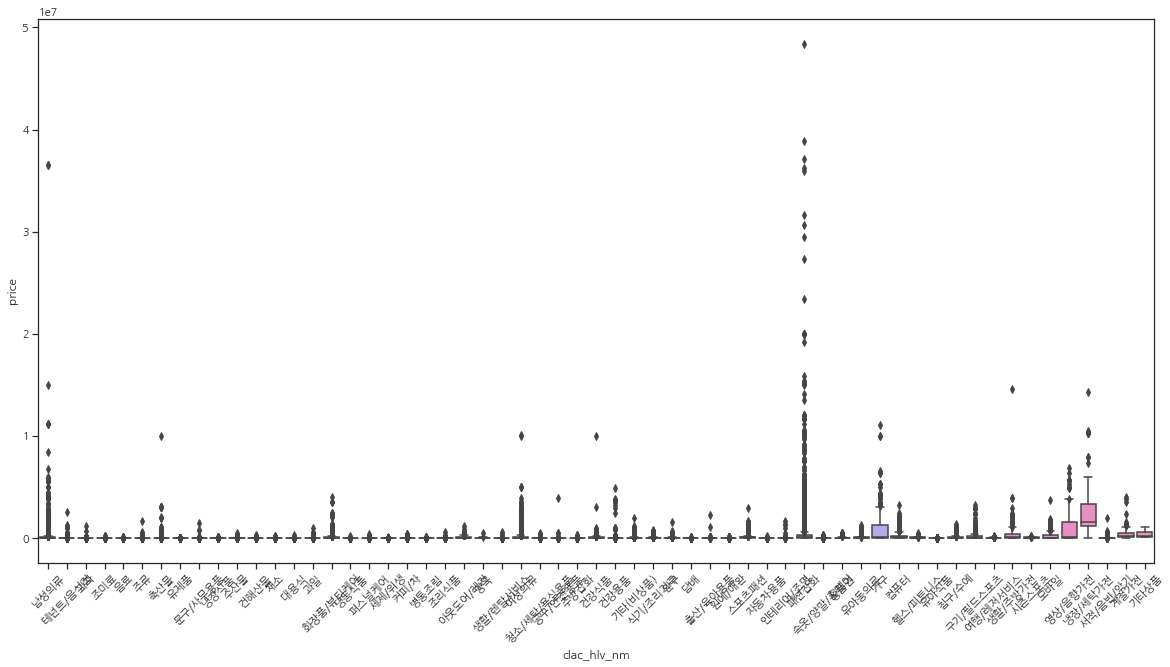

In [108]:
plt.figure(figsize=(20,10))
sns.boxplot(data = data_40_m, x = "clac_hlv_nm",y="price")
plt.xticks(rotation=45)
plt.show()

In [98]:
def get_outlier(df=None, column=None, weight=1.5):
    # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    outlier_idx = df[column][ (df[column] > highest) ].index
    return outlier_idx

In [109]:
outlier_index_fe = []

for i in data_40_fe.clac_hlv_nm.unique():
    outlier_index_fe.append(get_outlier(df=data_40_fe[data_40_fe["clac_hlv_nm"]==i], column='price', weight=1.5))

outlier_index_m = []

for i in data_40_m.clac_hlv_nm.unique():
    outlier_index_m.append(get_outlier(df=data_40_m[data_40_m["clac_hlv_nm"]==i], column='price', weight=1.5))


In [110]:
for i in outlier_index_fe:
    data_40_fe.drop(i, axis=0, inplace=True)

C:\Users\bsmon\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [111]:
for i in outlier_index_m:
    data_40_m.drop(i, axis=0, inplace=True)

In [112]:
expensive = data_40_m.pivot_table(index = ["pd_nm"],values=["price"],aggfunc="max").sort_values(by="price").sort_values(by="price",ascending=False)
expensive.reset_index()

,pd_nm,price
0,드럼세탁기,5972000.0
1,양문형냉장고,4822000.0
2,UHD,3785000.0
3,냉장/냉동가전소모품,3497000.0
4,스탠드형김치냉장고,3230000.0
...,...,...
1619,여아한복,100.0
1620,영유아스커트,100.0
1621,의류스타일러,100.0
1622,기타여아특수목적의류,100.0


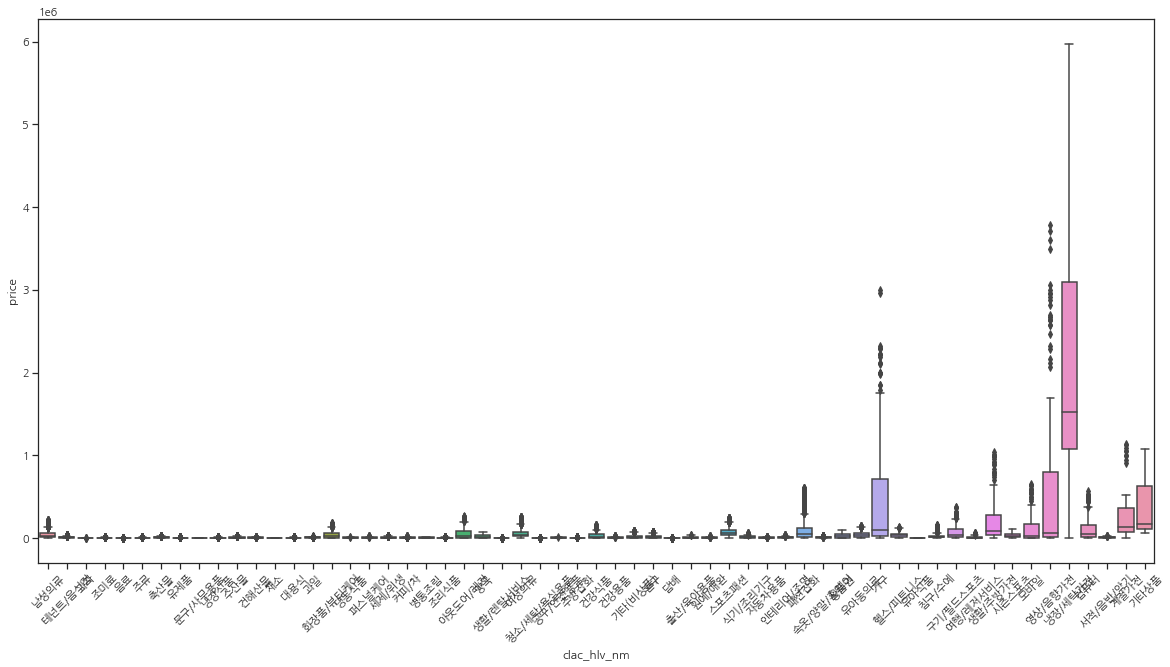

In [113]:
plt.figure(figsize=(20,10))
sns.boxplot(data = data_40_m, x = "clac_hlv_nm",y="price")
plt.xticks(rotation=45)
plt.show()

In [117]:
col = data_40_fe.clac_hlv_nm.apply(lambda x : x.replace("/","."))
col_mc = data_40_fe.clac_mcls_nm.apply(lambda x : x.replace("/","."))

In [131]:
data_40_fe["clac_mcls_nm"] = col_mc
data_40_fe["clac_hlv_nm"] = col

In [132]:
data_40_fe

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,...,ages,zon_hlv,pd_nm,clac_hlv_nm,clac_mcls_nm,Date,Day,weather,Rain_status,price
5,M506355556,A01000165972,1.0,A01,A010032,PD0290,2021-01-01,16.0,29000.0,1.0,...,40대,Z17,남성티셔츠,남성의류,남성의류상의,2021-01-01,fri,cold,no_rain,29000.0
16,M081569058,A01000297171,1.0,A01,A010053,PD0290,2021-01-01,19.0,39800.0,1.0,...,40대,Z10,남성티셔츠,남성의류,남성의류상의,2021-01-01,fri,cold,no_rain,39800.0
36,M243577483,A01000055024,1.0,A01,A010053,PD1692,2021-01-01,13.0,5800.0,1.0,...,40대,Z10,커피/음료,테넌트.음식점,식당,2021-01-01,fri,cold,no_rain,5800.0
37,M243577483,A01000055024,1.0,A01,A010053,PD1692,2021-01-01,13.0,5300.0,1.0,...,40대,Z10,커피/음료,테넌트.음식점,식당,2021-01-01,fri,cold,no_rain,5300.0
48,M331473499,A01000231659,1.0,A01,A010039,PD1692,2021-01-01,17.0,5400.0,1.0,...,40대,Z10,커피/음료,테넌트.음식점,식당,2021-01-01,fri,cold,no_rain,5400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381695,M556347395,A02082967117,1.0,A02,A020015,PD0449,2021-11-18,14.0,3520.0,1.0,...,40대,Z10,복사용지,문구.사무용품,사무용지.서식지,2021-11-18,thu,warm,no_rain,3520.0
4381696,M950449432,A02167913812,1.0,A02,A020044,PD0449,2021-11-18,11.0,3280.0,1.0,...,40대,Z10,복사용지,문구.사무용품,사무용지.서식지,2021-11-18,thu,warm,no_rain,3280.0
4381710,M701933325,E03011248089,2.0,A03,NaN,PD1520,2021-11-18,17.0,15920.0,1.0,...,40대,Z17,수입산소갈비,축산물,기타국소고기,2021-11-18,thu,warm,no_rain,15920.0
4381711,M097595988,E06050366839,2.0,A06,NaN,PD1520,2021-11-18,20.0,22320.0,1.0,...,40대,Z17,수입산소갈비,축산물,기타국소고기,2021-11-18,thu,warm,no_rain,22320.0


In [133]:
data_40_fe_wr = data_40_fe[(data_40_fe.weather =="warm")&(data_40_fe.Rain_status=="rain")]

#mask = data_40_fe_wr.clac_hlv_nm.apply(lambda x : x in fashion)
#data_40_fe_wr_fa = data_40_fe_wr[mask]

In [134]:
# 더울 때
for i in data_40_fe_wr.clac_mcls_nm.unique():
    temp_data = data_40_fe_wr[data_40_fe_wr.clac_mcls_nm == i]
    temp_pivot =temp_data.pivot_table(index=["ages","ma_fem_dv"],columns = ["pd_nm"],values="buy_am",aggfunc="sum").reset_index()
    female = temp_pivot[temp_pivot["ma_fem_dv"] == "여성"]

    female_sum = female.T.reset_index()[2:]
    female_sum.columns = ["name","sum"]
    top_20 = female_sum.sort_values(ascending=False, by = "sum")[0:21]
    plt.figure(figsize=(20,10))
    sns.barplot(data = top_20, x = "name", y="sum")
#     order = temp_data.pd_nm.value_counts().sort_values(ascending = False).index[0:21]
#     sns.countplot(data = temp_data, x = "pd_nm",order = order)
    file_path = "C:/Users/bsmon/OneDrive/바탕 화면/fe_wr/"
    file_name = file_path + i + ".png"
    plt.title(i)
    plt.xticks(rotation = 45)
    plt.savefig(file_name,
                facecolor='#eeeeee',
                edgecolor='black')
    plt.close()

# 모델 생성
* 추천 시스템 중 유저 기반 하이브리드 모델을 사용
* 코사인 유사도를 활용, 비슷한 유저를 찾아 해당 유저보다 덜 구매한 품목을 추천해줌

In [140]:
food = ["국산과일","냉동과일","미국산소고기","생선회","아이스크림"
        ,"열매채소","온장조리","잎채소","조개류","프리믹스","차류"]

In [307]:
hobby = ["등산","수영.물놀이","수예소품","실외놀이.스포츠완구","스키.보드","야구","여행용가방류","캠핑"]

In [376]:
fashion = ["남성속옷","남성의류아우터","캐쥬얼가방","핸드.풋케어","향수","메이크업"]

In [395]:
data_40_m_wr = data_40_m[(data_40_m.weather =="cold")]

mask = data_40_m_wr.clac_mcls_nm.apply(lambda x : x in fashion)
data_40_m_wr_fa = data_40_m_wr[mask]

# data_40_fe_wr_fa = data_40_fe_wr[data_40_fe_wr.clac_hlv_nm =="시즌스포츠"]

In [397]:
pivot = data_40_m_wr_fa.pivot_table(index=["cust"],columns = ["pd_nm"],values="buy_am",aggfunc="sum")

In [398]:
pivot = pivot.fillna(0)

In [399]:
pivot

pd_nm,BB/파운데이션/컴팩트류,기타남성의류아우터,남녀공용향수,남녀공용향수세트,남성내의,남성런닝셔츠,남성사파리,남성점퍼,남성정장재킷,남성캐주얼재킷,...,아동용가방,아이라이너,아이브로우,아이섀도우,여성향수,일반네일/케어류,캐쥬얼백팩,캐쥬얼숄더백,캐쥬얼힙색,학생용가방
cust,,,,,,,,,,,,,,,,,,,,,
M003574741,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129000.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M005392126,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M010049359,0.0,0.0,0.0,0.0,9900.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M017850235,0.0,0.0,153000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M021136955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M939854873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,84000.0,0.0,0.0,0.0,0.0,0.0,0.0
M948101415,235000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
M952029586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,399000.0


In [400]:
from surprise import SVD
from surprise.model_selection import cross_validate
from sklearn.decomposition import randomized_svd,non_negative_factorization

In [401]:
def compute_cos_similarity(v1,v2):
    norm1 = np.sqrt(np.sum(np.square(v1)))
    norm2 = np.sqrt(np.sum(np.square(v2)))
    dot = np.dot(v1,v2)
    return dot / (norm1*norm2)

In [402]:
adj_matrix = np.array(pivot)

In [403]:
U,S,V = randomized_svd(adj_matrix,n_components=2)
S = np.diag(S)

In [445]:
my_id, my_vector = 1, U[1]
best_match, best_match_id, best_match_vector = -1,-1,[]

for user_id, user_vector in enumerate(U):
    if my_id != user_id:
        cos_similarity = compute_cos_similarity(my_vector,user_vector)
        if cos_similarity > best_match:
            best_match = cos_similarity
            best_match_id = user_id
            best_match_vector = user_vector

print("Best Match: {}, Best Match ID: {}".format(best_match,best_match_id))

Best Match: 1.0000000000000002, Best Match ID: 9


In [446]:
recommend_list = {}
for i, log in enumerate(zip(adj_matrix[my_id],adj_matrix[best_match_id])):
    log1,log2 = log

    if log2 - log1 > 0:
        recommend_list[i] = log2-log1

recommend = sorted(recommend_list.items(), key = lambda item: item[1], reverse = True)
print(recommend)

[(15, 1000.0)]


In [447]:
#cust = M000225114
a = pd.DataFrame(pivot.iloc[my_id,:])
user_id = a.columns[0]
a[a[user_id] > 0]

,M005392126
pd_nm,
립스틱/립라이너,48000.0


In [448]:
a = pd.DataFrame(pivot.iloc[best_match_id,:])
user_id = a.columns[0]
a[a[user_id] > 0]

,M072865783
pd_nm,
립스틱/립라이너,49000.0


In [449]:
ind = pivot.iloc[0,:].index
rec_list = [x[0] for x in recommend ]
pd.DataFrame(ind[rec_list])

,pd_nm
0,립스틱/립라이너
